In [82]:
import conllu
import string
import pandas as pd
from tqdm import tqdm

from sklearn import linear_model, metrics
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import string

from nlp_preprocessing_toolbox.helper import __fixation, tokenizer_load_and_parse_corpus

In [73]:
data_file = open("nlp_preprocessing_toolbox/data/UD_Turkish-BOUN/tr_boun-ud-train.conllu", "r", encoding="utf-8")
# data_file = open("nlp_preprocessing_toolbox/data/UD_Turkish-Penn/tr_penn-ud-train.conllu", "r", encoding="utf-8")

text = data_file.read()

df = pd.DataFrame()

lines = []

new_text = " "
labels = []
for item in tqdm(conllu.parse(text)):
    last_id = 0
    for i in range(len(item)):
        
        if type(item[i]["id"]) == tuple:
            if item[i]["id"][0] > last_id: valid = True
            else: continue
        else:
            if item[i]["id"] > last_id: valid = True
            else: continue

        if type(item[i]["id"]) == tuple: last_id = item[i]["id"][-1]
        else: last_id = item[i]["id"]

        ##########################
        token = item[i]["form"]
        iter_len = len(token)
        

        for idx in range(iter_len):

            if idx == iter_len-1: label = 1
            else: label = 0
            new_text += token[idx]
            
            labels.append(label)
            
            row = {
                "char" : token[idx],
                "label" : label
            }
            lines.append(row)
            
        try:
            if item[i]["misc"]["SpaceAfter"] == "No": pass
            else: 
                new_text = new_text + " "
                row = {
                    "char" : " ",
                    "label" : 0
                }
                lines.append(row)
        except:
            new_text = new_text + " "
            row = {
                "char" : " ",
                "label" : 0
            }
            lines.append(row)

df_raw = pd.DataFrame.from_records(lines)

100%|████████████████████████████████████████████████████████████████████████████| 7803/7803 [00:02<00:00, 3374.71it/s]


In [75]:
df_raw["t-1"] = df_raw.char.shift(1)
df_raw["t-2"] = df_raw.char.shift(2)
df_raw["t+1"] = df_raw.char.shift(-1)
df_raw["t+2"] = df_raw.char.shift(-2)

In [76]:
for col in ["char", "t-1", "t-2", "t+1", "t+2"]:
    df_raw[col + "_punc"] = [True if (str(val) in string.punctuation) else False for val in df_raw[col].values]
    df_raw[col + "_num"] = [True if (str(val).isnumeric()) else False for val in df_raw[col].values]    
    df_raw[col + "_space"] = [True if (str(val) == " ") else False for val in df_raw[col].values]    
    df_raw[col + "_period"] = [True if (str(val) == "." ) else False for val in df_raw[col].values]
    
df_raw = df_raw.dropna()

In [77]:
req_cols = ["char"]
for col in ["char", "t-1", "t-2", "t+1", "t+2"]:
    for suff in ["_punc", "_num", "_space", "_period"]:
        req_cols.append(col+suff)
req_cols.append("label")

In [78]:
df = df_raw[req_cols]
df = df[df.columns[1:]]
df = df.astype(int)

In [80]:
train_test_split = int(len(df)*0.8)
dfTrain, dfTest = df[0:train_test_split], df[train_test_split:]

X_train = dfTrain.values[:,0:-1]
y_train = dfTrain.values[:,-1]

X_test = dfTest.values[:,0:-1]
y_test = dfTest.values[:,-1]

In [83]:
logr = linear_model.LogisticRegression()
logr.fit(X_train,y_train)

LogisticRegression()

C:\Users\gocal\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


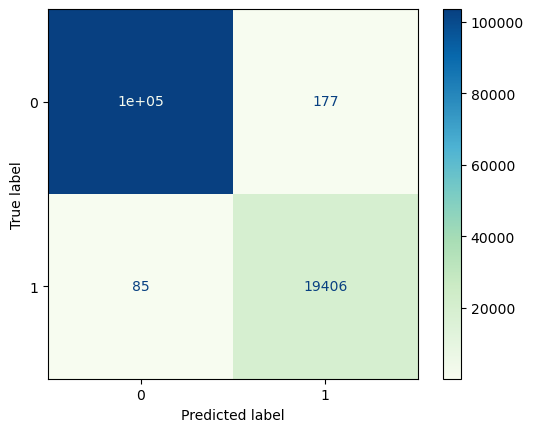

In [84]:
confusion_matrix = metrics.plot_confusion_matrix(logr, X_test, y_test, cmap = "GnBu")
plt.show()

In [90]:
text = '''Saçma ve Gereksiz Bir Yazı.
Bakkaldan 5 TL'lik 2 çikola-
ta al. 12.02.2018 tarihinde saat tam 15:45'te yap-
malıyız bu işi. Tamam mı? Benimle esatmahmutbayol@gmail.com 
adresinden iletişime geçebilirsin. Yarışta 1. oldu. Doç. Dr. 
Esat Bayol'un(Böyle bir ünvanım yok!) yanından geliyorum.
12 p.m. mi yoksa 12 a.m. mi? 100 milyon insan gelmiş! www.deneme.com.tr 
adresinden sitemizi inceleyebilirsin. 24 Eylül 2018 Pazartesi günü ge-
lecekmiş. 19 Mayıs'ı coşkuyla kutladık.
Sonra dedi ki "Ben seni sevmiyorum."'''

text = __fixation(text).replace("\n", " ")

text = "  " + text + "  "

lines = []
for idx, char in enumerate(text):
    row = {
        "char" : char
    }
    lines.append(row)
    
df_text = pd.DataFrame.from_records(lines)

df_text["t-1"] = df_text.char.shift(1)
df_text["t-2"] = df_text.char.shift(2)
df_text["t+1"] = df_text.char.shift(-1)
df_text["t+2"] = df_text.char.shift(-2)

for col in ["char", "t-1", "t-2", "t+1", "t+2"]:
    df_text[col + "_punc"] = [True if (str(val) in string.punctuation) else False for val in df_text[col].values]
    df_text[col + "_num"] = [True if (str(val).isnumeric()) else False for val in df_text[col].values]    
    df_text[col + "_space"] = [True if (str(val) == " ") else False for val in df_text[col].values]    
    df_text[col + "_period"] = [True if (str(val) == "." ) else False for val in df_text[col].values]
    
df_text = df_text.dropna()
df_text = df_text[req_cols[0:-1]]
df_real_test = df_text[df_text.columns[1:]]
df_real_test = df_real_test.astype(int)

df_real_test

,char_punc,char_num,char_space,char_period,t-1_punc,t-1_num,t-1_space,t-1_period,t-2_punc,t-2_num,t-2_space,t-2_period,t+1_punc,t+1_num,t+1_space,t+1_period,t+2_punc,t+2_num,t+2_space,t+2_period
2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
504,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
505,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0
506,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [91]:
pred = logr.predict(df_real_test)
df_text["label"] = pred
df_text

C:\Users\gocal\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,char,char_punc,char_num,char_space,char_period,t-1_punc,t-1_num,t-1_space,t-1_period,t-2_punc,...,t-2_period,t+1_punc,t+1_num,t+1_space,t+1_period,t+2_punc,t+2_num,t+2_space,t+2_period,label
2,S,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,0
3,a,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,ç,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
5,m,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0
6,a,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,r,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
504,u,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,0
505,m,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,True,False,False,False,1
506,.,True,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,0


In [93]:
tokens = []
last_idx = 0
temp = ""
for idx, row in df_text.iterrows():
    if row.label == 0: temp += row.char
    elif row.label == 1:
        temp += row.char
        tokens.append(temp.strip())
        temp = ""
        last_idx = idx
tokens

['Saçma',
 've',
 'Gereksiz',
 'Bir',
 'Yazı',
 '.',
 'Bakkaldan',
 '5',
 "TL'lik",
 '2',
 'çikolata',
 '',
 'al',
 '.',
 '12.02.2018',
 'tarihinde',
 'saat',
 'tam',
 '15:',
 "45'te",
 'yapmalıyız',
 '',
 'bu',
 'işi',
 '.',
 'Tamam',
 'mı',
 '?',
 'Benimle',
 'esatmahmutbayol@gmail',
 '.com',
 '',
 'adresinden',
 'iletişime',
 'geçebilirsin',
 '.',
 'Yarışta',
 '1',
 '.',
 'oldu',
 '.',
 'Doç',
 '.',
 'Dr',
 '.',
 '',
 'Esat',
 "Bayol'un(Böyle",
 'bir',
 'ünvanım',
 'yok',
 '!',
 ')',
 'yanından',
 'geliyorum',
 '.',
 '12',
 'p',
 '.m',
 '.',
 'mi',
 'yoksa',
 '12',
 'a',
 '.m',
 '.',
 'mi',
 '?',
 '100',
 'milyon',
 'insan',
 'gelmiş',
 '!',
 'www',
 '.deneme',
 '.com',
 '.tr',
 '',
 'adresinden',
 'sitemizi',
 'inceleyebilirsin',
 '.',
 '24',
 'Eylül',
 '2018',
 'Pazartesi',
 'günü',
 'gelecekmiş',
 '.',
 '',
 '19',
 "Mayıs'",
 'ı',
 'coşkuyla',
 'kutladık',
 '.',
 'Sonra',
 'dedi',
 'ki',
 '"',
 'Ben',
 'seni',
 'sevmiyorum',
 '."']